In this version, we will use the same architecture we train and tested on a test set to predict 30 days in the future.

In [21]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [22]:
def get_stockDF(name):
    """
    For real-time, only need to modify this function to get real-time dataframe
    """
    df = pd.read_csv(name)
    df = df.iloc[::-1]
    del df['Unnamed: 0']
    return df
df = get_stockDF("NFLX.csv")

In [23]:
def preprocess(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    y = df['close']
    y = y.values.reshape(-1,1)
    scaler = scaler.fit(y)
    y = scaler.transform(y)
    return y, scaler
    
stock, scaler = preprocess(df)

In [24]:
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

def generate_XY(stock):
    """
    This function will generate X,Y as X train and Y train
    Will be modified to be updated regularly
    """
    X = []
    Y = []

    for i in range(n_lookback, (len(stock)) - n_forecast + 1):
        X.append(stock[i - n_lookback: i])
        Y.append(stock[i: i + n_forecast])

    X = np.array(X)
    Y = np.array(Y)
    return X,Y


In [25]:

def train(X,Y):
    """
    Train model
    """
    np.random.seed(1234)
    tf.random.set_seed(1234)
    model = Sequential()
    model.add(LSTM(units=30,return_sequences=True,input_shape=(n_lookback, 1), activation = 'relu'))
    model.add(LSTM(units=30,return_sequences=True, activation = 'relu'))
    model.add(LSTM(units=30,return_sequences=True, activation = 'relu'))
    model.add(LSTM(units=30, activation = 'relu'))
    model.add(Dense(n_forecast))
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(X, Y,epochs=100,batch_size=32)
    model.summary()
    model.save('future.h5')

def run(stock):
    """
    Run the training algorithm on the historical data
    """
    X_,Y_ = generate_XY(stock)
    train(X_,Y_)


In [26]:
def gen_forecasts(stock):
    """
    Generate forecasts from the updated model
    @stock: preprocessed stock variable
    @return: Y_ the forecast prices for the next 30 days
    """

    model = tf.keras.models.load_model('future.h5')

    X_ = stock[-n_lookback:]  # last available input sequence
    X_ = X_.reshape(1, n_lookback, 1)

    Y_ = model.predict(X_).reshape(-1, 1)
    Y_ = scaler.inverse_transform(Y_)

    return Y_


In [27]:
"""Data frame of the forecasts
#Append two of them to the variable results
Plot both
"""
def gen_dfPast(df):
    df_past = df[['close']]
    df_past['date'] = pd.to_datetime(df['date'])
    df_past['forecast'] = np.nan
    return df_past
def gen_dfFuture(df_past, forecast):
    df_future = pd.DataFrame(columns=['close', 'date', 'forecast'])
    df_future['date'] = pd.date_range(start=df_past['date'].iloc[-1] + pd.Timedelta(minutes=1), periods=n_forecast)
    df_future['forecast'] = forecast.flatten()
    results = df_past.append(df_future).set_index('date')
    return results, df_future

def plot_pred(results):
    plt.figure(figsize=(16,6))
    plt.title('30 days predictions')
    plt.plot(results)
    #Uncomment this when real-time is fully implemented
    # plt.savefig('real1.png', dpi = 300, bbox_inches = 'tight')

In [28]:
def plot_pred2(df_future):
    future = df_future.set_index('date') 
    future.plot()

In [29]:
run(stock)

Epoch 1/100
37/37 [==============================] - 3s 29ms/step - loss: 0.1781
Epoch 2/100
37/37 [==============================] - 1s 29ms/step - loss: 0.0384
Epoch 3/100
37/37 [==============================] - 1s 30ms/step - loss: 0.0160
Epoch 4/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0109
Epoch 5/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0093
Epoch 6/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0084
Epoch 7/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0079
Epoch 8/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0080
Epoch 9/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0080
Epoch 10/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0081
Epoch 11/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0073
Epoch 12/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0073
Epoch 13/100
37/37 [=====

1/1 [==============================] - 0s 253ms/step


/var/folders/x5/l8x4kr756xq3xt39yzgv1_b80000gn/T/ipykernel_44940/128857731.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['date'] = pd.to_datetime(df['date'])
/var/folders/x5/l8x4kr756xq3xt39yzgv1_b80000gn/T/ipykernel_44940/128857731.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['forecast'] = np.nan
/var/folders/x5/l8x4kr756xq3xt39yzgv1_b80000gn/T/ipykernel_44940/128857731.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

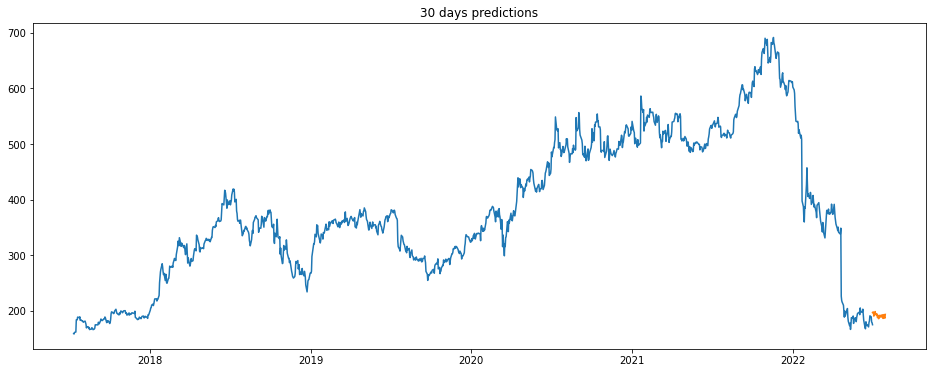

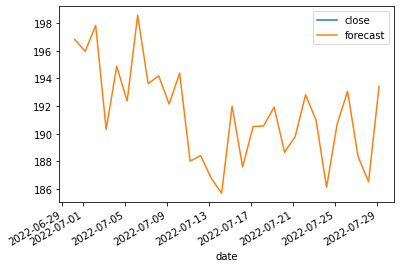

In [30]:
def run_stock():
    forecast = gen_forecasts(stock)
    dfPast = gen_dfPast(df)
    results, dfFuture = gen_dfFuture(dfPast, forecast)
    plot_pred(results)
    plot_pred2(dfFuture)
run_stock()